In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, models
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

In [2]:
import os
import datetime
import random
from PIL import Image

In [3]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.optim as optim

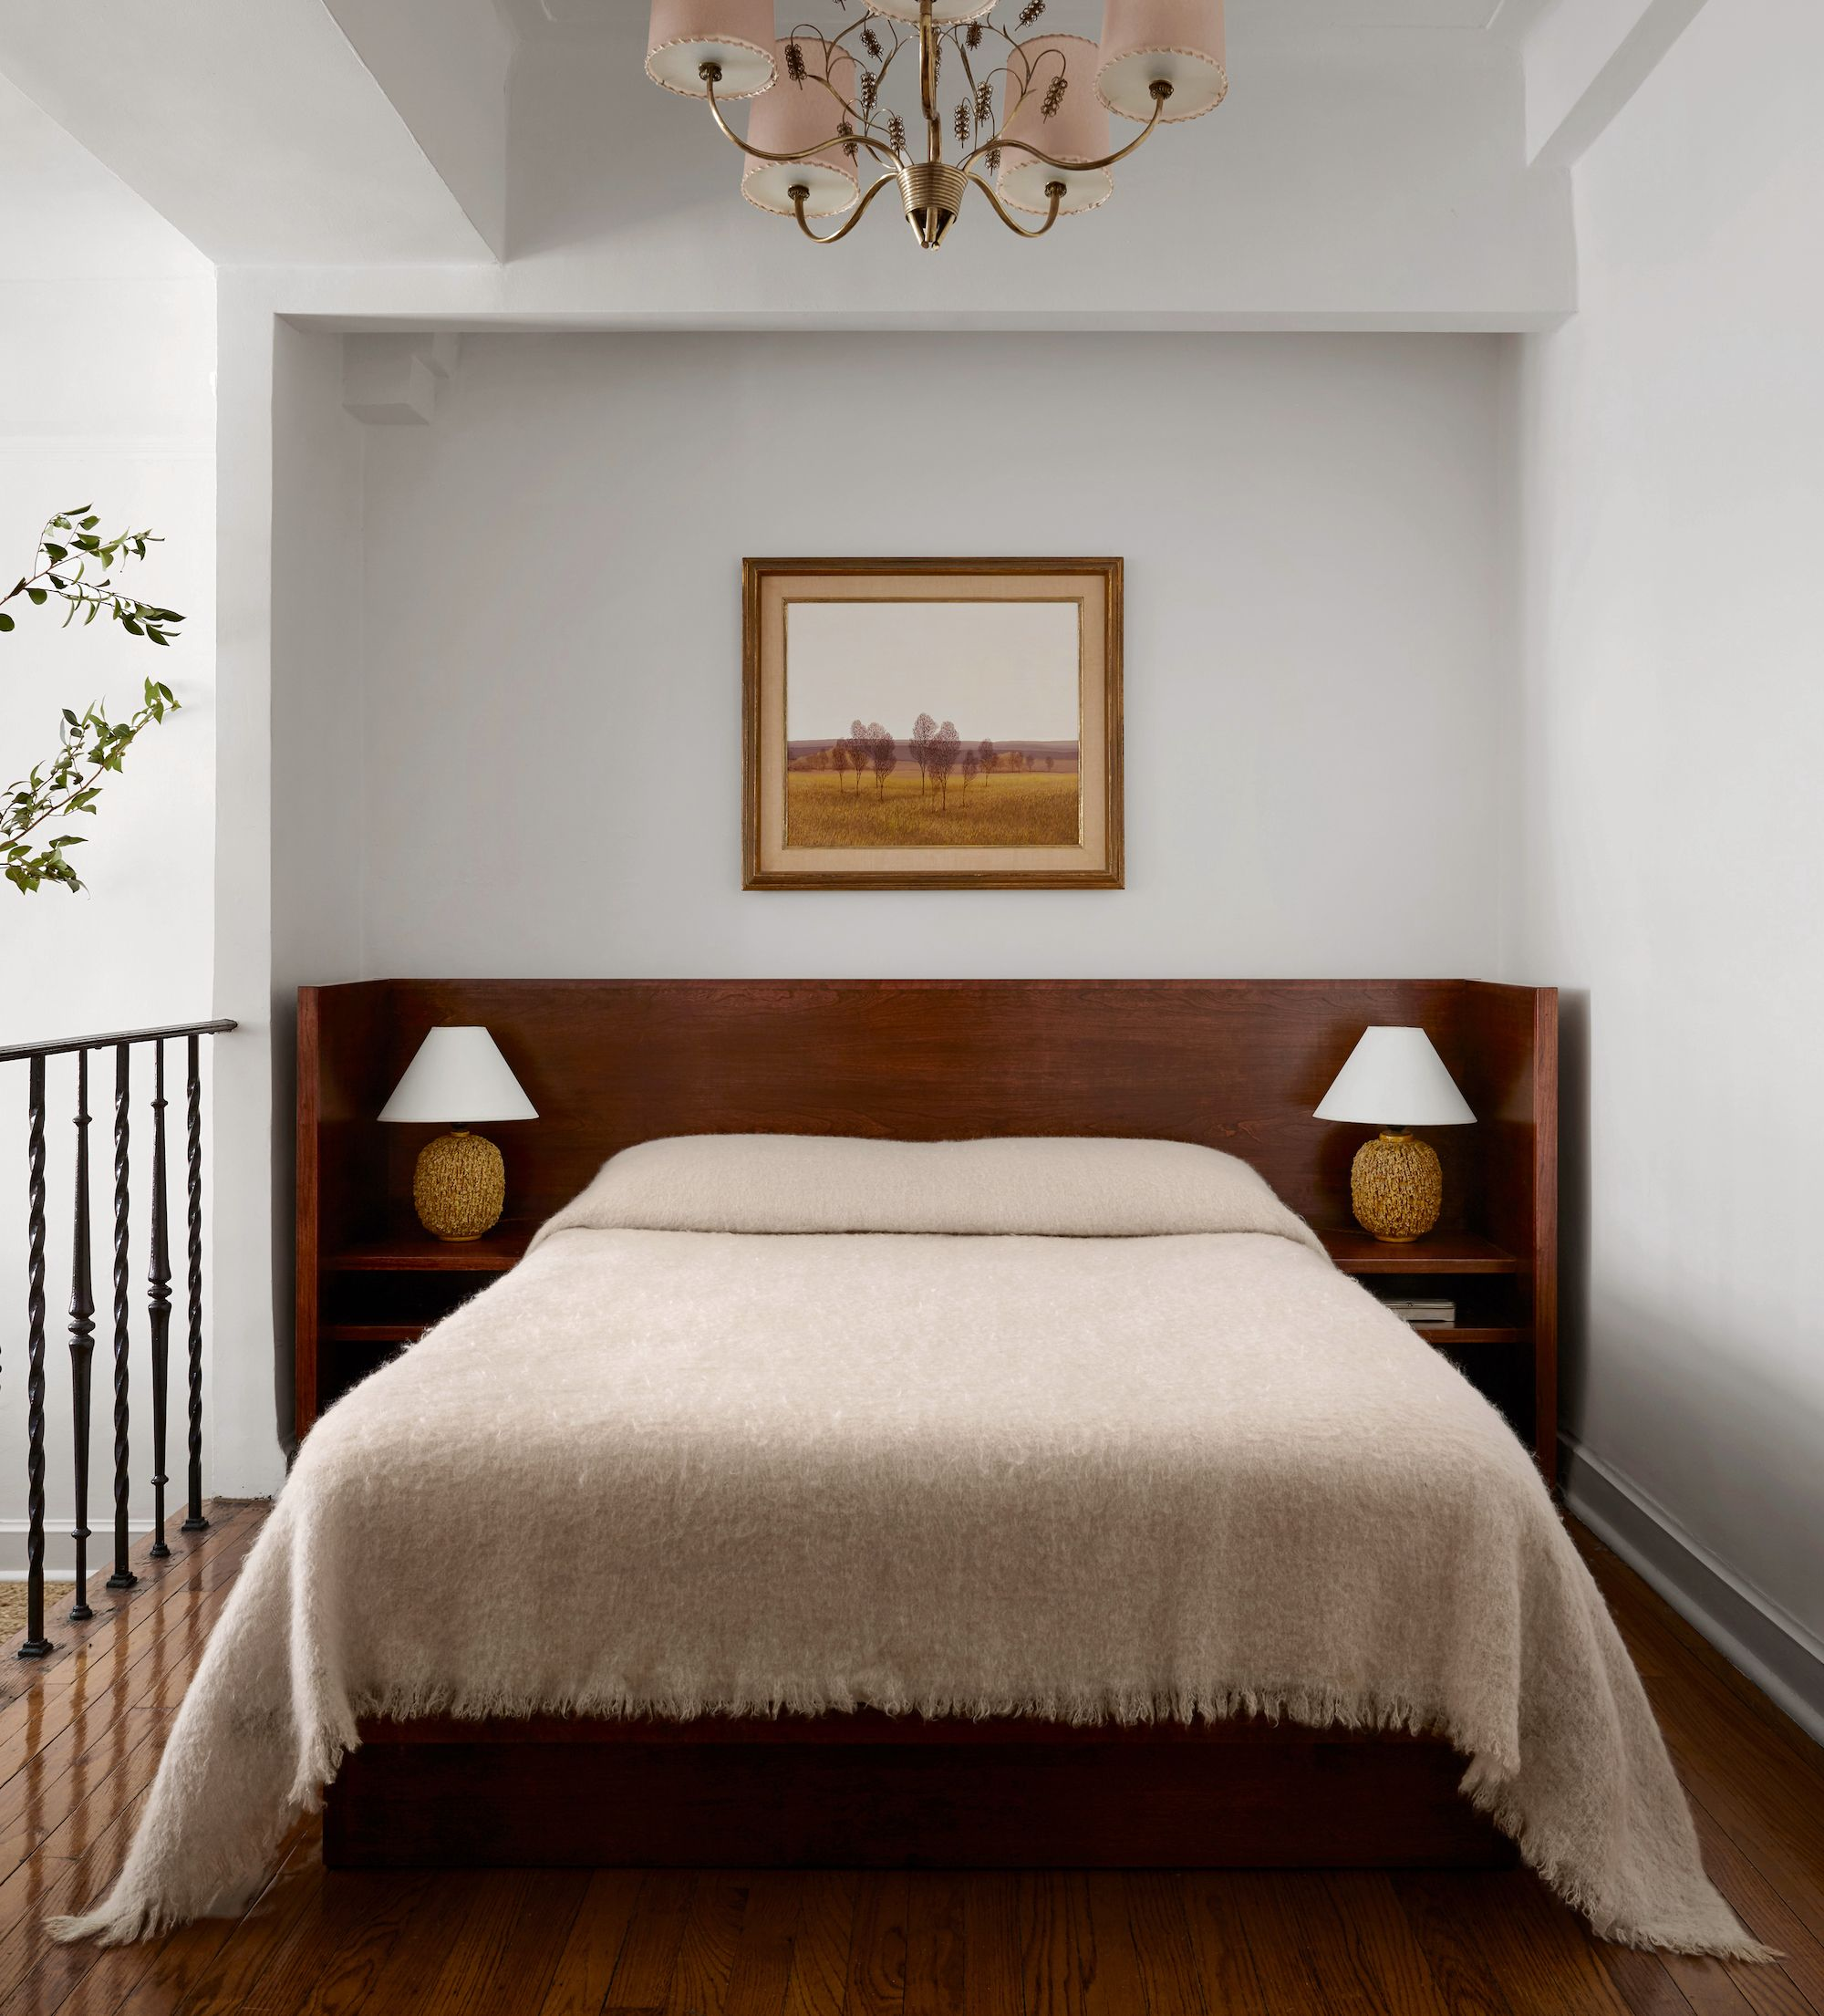

In [4]:
img = Image.open("test5.jpg")
img

In [5]:
np_img = np.array(img)

In [6]:
class DDN(nn.Module):
    def __init__(self):
        super(DDN, self).__init__()
        
        self.encoder = models.densenet169(weights=True, progress=True)
        self.encoder = nn.Sequential(*list(self.encoder.children())[:-1])
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.ConvTranspose2d(1664, 16,kernel_size=3, stride=1, padding=1,bias=False),
            nn.ConvTranspose2d(16, 8, kernel_size=2, stride=2, bias=False),
            nn.ConvTranspose2d(8, 4, kernel_size=2, stride=2, bias=False),
            nn.ConvTranspose2d(4, 2, kernel_size=2, stride=2, bias=False),
            nn.ConvTranspose2d(2, 1, kernel_size=2, stride=2, bias=False),
            
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [7]:
class UpSample(nn.Sequential):
    def __init__(self, skip_input, output_features):
        super(UpSample, self).__init__()        
        self.convA = nn.Conv2d(skip_input, output_features, kernel_size=3, stride=1, padding=1)
        self.leakyreluA = nn.LeakyReLU(0.2)
        self.convB = nn.Conv2d(output_features, output_features, kernel_size=3, stride=1, padding=1)
        self.leakyreluB = nn.LeakyReLU(0.2)

    def forward(self, x, concat_with):
        up_x = F.interpolate(x, size=[concat_with.size(2), concat_with.size(3)], mode='bilinear', align_corners=True)
        return self.leakyreluB( self.convB( self.convA( torch.cat([up_x, concat_with], dim=1)  ) )  )

class Decoder(nn.Module):
    def __init__(self, num_features=1664, decoder_width = 1.0):
        super(Decoder, self).__init__()
        features = int(num_features * decoder_width)

        self.conv2 = nn.Conv2d(num_features, features, kernel_size=1, stride=1, padding=0)

        self.up1 = UpSample(skip_input=features//1 + 256, output_features=features//2)
        self.up2 = UpSample(skip_input=features//2 + 128,  output_features=features//4)
        self.up3 = UpSample(skip_input=features//4 + 64,  output_features=features//8)
        self.up4 = UpSample(skip_input=features//8 + 64,  output_features=features//16)

        self.conv3 = nn.Conv2d(features//16, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, features):
        x_block0, x_block1, x_block2, x_block3, x_block4 = features[3], features[4], features[6], features[8], features[12]
        x_d0 = self.conv2(F.relu(x_block4))

        x_d1 = self.up1(x_d0, x_block3)
        x_d2 = self.up2(x_d1, x_block2)
        x_d3 = self.up3(x_d2, x_block1)
        x_d4 = self.up4(x_d3, x_block0)
        return self.conv3(x_d4)

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()       
        self.original_model = models.densenet169( weights=True )

    def forward(self, x):
        features = [x]
        for k, v in self.original_model.features._modules.items(): features.append( v(features[-1]) )
        return features

class PTModel(nn.Module):
    def __init__(self):
        super(PTModel, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        return self.decoder( self.encoder(x) )

In [8]:
model = PTModel()

d:\python\python37\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
model.load_state_dict(torch.load(".\\model\\PTModel\\2023-12-11_17-41_0.007553307805210352_0.pth"))

<All keys matched successfully>

In [10]:
tensor = torch.tensor(np_img)

In [11]:
rgb_trans = A.Compose([
                A.Resize(width = 224, height = 224),
                A.Normalize(
                       mean = [0.0, 0.0, 0.0],
                        std = [1.0, 1.0, 1.0],
                        max_pixel_value=255.0
                    ),
                
                
                ToTensorV2()
            ])

In [12]:
tensor = rgb_trans(image = np_img)["image"]

In [13]:
r = model(tensor.unsqueeze(0))

In [17]:
tensor.unsqueeze(0).shape

torch.Size([1, 3, 224, 224])

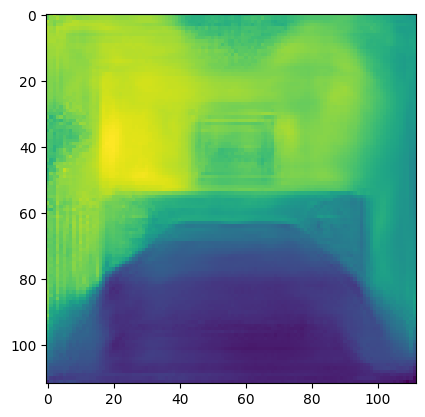

<Figure size 640x480 with 0 Axes>

In [14]:
plt.imshow((r[0] * 255).permute(1,2,0).detach().numpy())
plt.show()
plt.savefig("D:\\DLStudy\\DepthSegmentation\\result2.jpg")

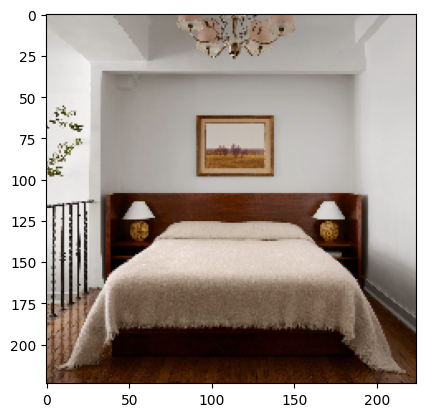

In [15]:
plt.imshow(tensor.permute(1,2,0))
plt.show()

In [16]:
from torch.utils.mobile_optimizer import optimize_for_mobile

In [19]:
example = torch.rand(1, 3, 224, 224)
traced_script_module = torch.jit.trace(model, example)
traced_script_module_optimized = optimize_for_mobile(traced_script_module)
traced_script_module_optimized._save_for_lite_interpreter("model.ptl")
